# Facial Recognition
1. Detect Face(s) using [`facenet`](https://github.com/timesler/facenet-pytorch)
2. Crop the Face(s)
3. Get Embedding for 1st Face Crop (Code will have to be changed for multiple faces)
4. Repeat the process for all the images and save image Embeddings in DB as a [`LanceDB`](https://github.com/lancedb/lancedb) Table
5. Take a Query Image and apply steps `1 to 3`
6. Query the Image in Table and get the Top-K matches

# Install Libraries
*Note*: Restart and run the below again if there are some dependency conflicts

In [10]:
!pip install  -U torch facenet_pytorch tqdm lancedb opencv-python matplotlib -qq

# Importing all libraries

In [11]:
import os
import lancedb
import re
import pickle
import requests
import zipfile
from pathlib import Path
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import os
import cv2
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
from tqdm import tqdm
from types import MethodType
import matplotlib.pyplot as plt


import pyarrow.compute as pc
import lance
from lancedb.embeddings import with_embeddings

# Get the Face Dataset

In [16]:
# Download small Facial Recognition Dtaset from here: https://vis-www.cs.umass.edu/lfw/
!wget http://vis-www.cs.umass.edu/lfw/lfw-a.tgz

# Unzip
!tar -xzf ./lfw-a.tgz -C ./

# Remove zip file
!rm -rf ./lfw-a.tgz

--2023-11-17 23:09:04--  http://vis-www.cs.umass.edu/lfw/lfw-a.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14486641 (14M) [application/x-gzip]
Saving to: ‘lfw-a.tgz’

lfw-a.tgz           100%[===================>]  13.82M  1.23MB/s    in 35s     

2023-11-17 23:09:41 (400 KB/s) - ‘lfw-a.tgz’ saved [14486641/14486641]



In [ ]:
BASE_DIR = "./lfw/"  # this is the base path where all our nested images reside
ALL_IMAGES = list(glob.glob(BASE_DIR + "*/*.jpg"))

## Load the data using pandas and describe the data

In [17]:
df = pd.DataFrame({"img_path": ALL_IMAGES})
df["person_name"] = df["img_path"].apply(lambda x: x.split("/")[2].replace("_", " "))

# Keep Entries who has Person Name atleast twice
df = df.groupby("person_name").filter(lambda x: len(x) > 1).reset_index(drop=True)

train, test = train_test_split(
    df, test_size=0.18, random_state=13, stratify=df["person_name"]
)
train  # train is just a name for the REFERENCE images which we'll use to save in the db

,img_path,person_name
46,./lfw/Alvaro_Uribe/Alvaro_Uribe_0035.jpg,Alvaro Uribe
696,./lfw/Andrew_Niccol/Andrew_Niccol_0002.jpg,Andrew Niccol
32,./lfw/Abdullah_al-Attiyah/Abdullah_al-Attiyah_...,Abdullah al-Attiyah
123,./lfw/Anna_Kournikova/Anna_Kournikova_0009.jpg,Anna Kournikova
713,./lfw/Ali_Khamenei/Ali_Khamenei_0001.jpg,Ali Khamenei
...,...,...
392,./lfw/Ana_Palacio/Ana_Palacio_0005.jpg,Ana Palacio
659,./lfw/Adrien_Brody/Adrien_Brody_0011.jpg,Adrien Brody
699,./lfw/Alexandra_Vodjanikova/Alexandra_Vodjanik...,Alexandra Vodjanikova
647,./lfw/Angela_Bassett/Angela_Bassett_0006.jpg,Angela Bassett


# Helper functions for Steps `1-3`

In [18]:
### helper function
def encode_one_image(img_path):
    res = None
    img = cv2.imread(img_path)
    with torch.no_grad():
        cropped = mtcnn(img)
        if cropped is not None:
            res = resnet(torch.Tensor(cropped))[0, :].detach().cpu().numpy()
        else:
            res = (
                np.ones(512) * 9999999
            )  # for No Embeddings, put a very high high or low value so there's no match
    return res


def detect_box(self, img, save_path=None):
    # Detect faces
    batch_boxes, batch_probs, batch_points = self.detect(img, landmarks=True)
    # Select faces
    if not self.keep_all:
        batch_boxes, batch_probs, batch_points = self.select_boxes(
            batch_boxes, batch_probs, batch_points, img, method=self.selection_method
        )
    # Extract faces
    faces = self.extract(img, batch_boxes, save_path)
    return batch_boxes, faces


### load model
resnet = InceptionResnetV1(pretrained="vggface2").eval()
mtcnn = MTCNN(
    image_size=224, keep_all=True, thresholds=[0.4, 0.5, 0.5], min_face_size=60
)
mtcnn.detect_box = MethodType(detect_box, mtcnn)

  0%|          | 0.00/107M [00:00<?, ?B/s]

# Create a New `LanceDB` Table and insert Embedding
(It'll open if it already exists)

In [19]:
def embed_func(batch):
    """
    Function to embed the whole data
    """
    return [encode_one_image(image_path) for image_path in batch]


db = lancedb.connect("./db")  # Connect Local DB
if "face_embed" in db.table_names():
    table = db.open_table("face_embed")  # Open Table
else:
    # Use the train data images to save embed in the DB
    data = with_embeddings(
        embed_func, train, column="img_path", show_progress=True, batch_size=32
    )
    table = db.create_table("face_embed", data=data)  # create Table

  0%|          | 0/20 [00:00<?, ?it/s]

# Search on a new query Image

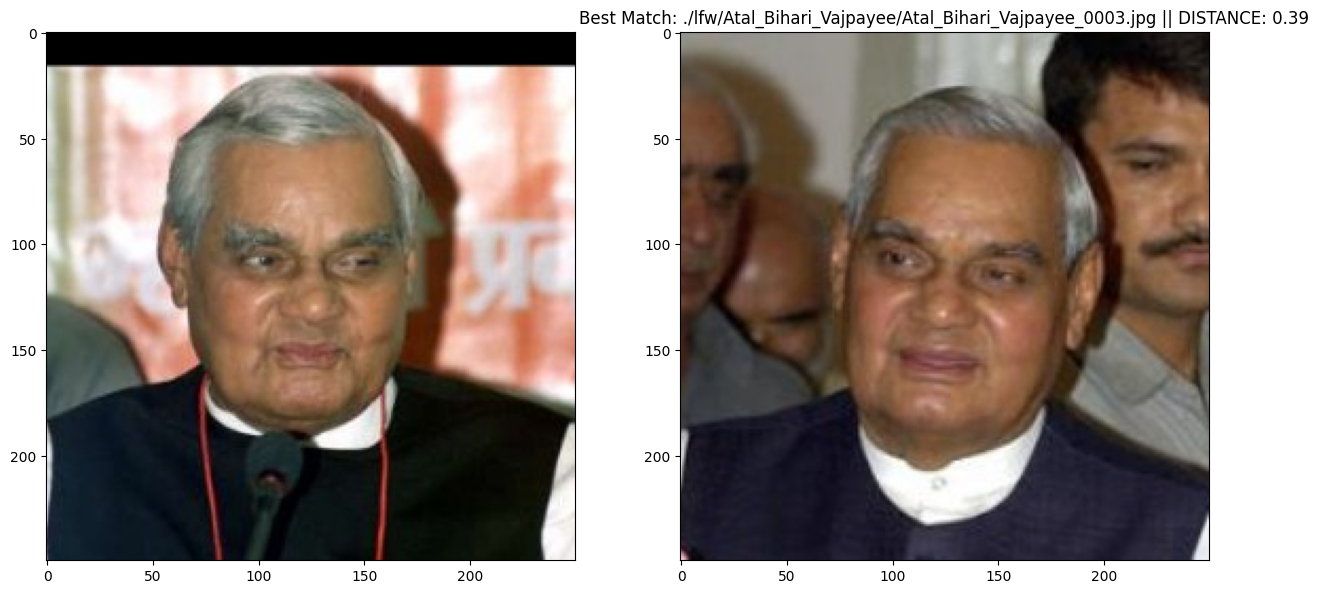


Top 3 Results for Query: ./lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0014.jpg



,img_path,person_name,vector,_distance
0,./lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpaye...,Atal Bihari Vajpayee,"[0.031648036, -0.006396611, -0.043956757, -0.0...",0.386577
1,./lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpaye...,Atal Bihari Vajpayee,"[0.043225817, 0.003474138, -0.06515207, 0.0187...",0.492828
2,./lfw/Atal_Bihari_Vajpayee/Atal_Bihari_Vajpaye...,Atal Bihari Vajpayee,"[0.0281102, -0.02962817, -0.077933036, -0.0450...",0.509371


In [20]:
# SEARCH
query_img_path = (
    test["img_path"].sample(1).values[0]
)  # Get 1 Random sample image from the Test

query_vector = embed_func([query_img_path])[0]

search_results = table.search(query_vector).limit(3)


f, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(plt.imread(query_img_path))

top_result = search_results.to_list()[0]
dist = top_result["_distance"]
res_img_path = top_result["img_path"]

ax[1].imshow(plt.imread(res_img_path))
ax[1].title.set_text(f"Best Match: {res_img_path} || DISTANCE: {round(dist, 2)}")

plt.show()

print(f"\nTop 3 Results for Query: {query_img_path}\n")
search_results.to_pandas()